
#### Disclaimer

ChatGPT was used for some plotting codes and learning PyTorch syntax. Some online public repositories were also used as reference on how to implement GANS 

#### References 
1. https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/

2.  https://github.com/Ksuryateja/DCGAN-CIFAR10-pytorch/blob/master/gan_cifar.py

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils

### Setting Hyperparameters for the data 



In [2]:
# Hyperparameters
batch_size = 128
image_size = 32  # CIFAR-10 image size
nz = 100  # Size of latent vector (input noise)
ngf = 64  # Generator feature map size
ndf = 64  # Discriminator feature map size
num_epochs = 50
lr = 0.0002  # Learning rate for optimizers
beta1 = 0.5  # Beta1 hyperparam for Adam optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Importing the CIFAR-10 Datasets

In [3]:
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

100%|█████████████████████████████████████████████████████| 170498071/170498071 [00:02<00:00, 64241457.26it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


### Defining Generator and Discriminator

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Input is the latent vector Z, going into a transposed conv layer
            # 100 neurons -> 64*8 output channels, kernels = 4, no padding, strided 1
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # Shape: (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # Shape: (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # Shape: (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # Shape: (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, 3, 3, 1, 1, bias=False),
            nn.Tanh()
            # Output: 3 x 32 x 32
        )

    def forward(self, input):
        return self.main(input)


In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # Input: 3 x 32 x 32
            nn.Conv2d(3, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # State size: (ndf) x 16 x 16
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # State size: (ndf*2) x 8 x 8
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # State size: (ndf*4) x 4 x 4
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
            # Output: 1 (real/fake)
        )

    def forward(self, input):
        return self.main(input)


### Initiailizations and Training 

In [6]:
netG = Generator().to(device)
netD = Discriminator().to(device)

criterion = nn.BCELoss()

fixed_noise = torch.randn(64, nz, 1, 1, device=device)

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))


In [7]:
real_label = 1.
fake_label = 0.

G_losses = []
D_losses = []

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        # Train Discriminator with real batch
        netD.zero_grad()
        real_images = data[0].to(device)
        b_size = real_images.size(0)
        labels = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = netD(real_images).view(-1)
        lossD_real = criterion(output, labels)
        lossD_real.backward()

        # Train Discriminator with fake batch
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake_images = netG(noise)
        labels.fill_(fake_label)
        output = netD(fake_images.detach()).view(-1)
        lossD_fake = criterion(output, labels)
        lossD_fake.backward()
        optimizerD.step()

        # Train Generator
        netG.zero_grad()
        labels.fill_(real_label)
        output = netD(fake_images).view(-1)
        lossG = criterion(output, labels)
        lossG.backward()
        optimizerG.step()

        # Output training stats
        if i % 100 == 0:
            print(f"Epoch [{epoch}/{num_epochs}] Step [{i}/{len(dataloader)}] Loss D: {lossD_real + lossD_fake}, Loss G: {lossG}")

        G_losses.append(lossG.item())
        D_losses.append((lossD_real + lossD_fake).item())

print("Training Finished!")


Epoch [0/50] Step [0/391] Loss D: 1.3562684059143066, Loss G: 1.5000519752502441
Epoch [0/50] Step [100/391] Loss D: 0.0680852010846138, Loss G: 6.256042957305908
Epoch [0/50] Step [200/391] Loss D: 0.4395732283592224, Loss G: 3.205855369567871
Epoch [0/50] Step [300/391] Loss D: 0.7114800214767456, Loss G: 3.420820951461792
Epoch [1/50] Step [0/391] Loss D: 0.6154671907424927, Loss G: 2.948664665222168
Epoch [1/50] Step [100/391] Loss D: 0.8008182644844055, Loss G: 2.159515380859375
Epoch [1/50] Step [200/391] Loss D: 0.8370609283447266, Loss G: 2.1425294876098633
Epoch [1/50] Step [300/391] Loss D: 0.7391601800918579, Loss G: 2.737288475036621
Epoch [2/50] Step [0/391] Loss D: 0.6288564205169678, Loss G: 2.8120269775390625
Epoch [2/50] Step [100/391] Loss D: 0.8469781279563904, Loss G: 1.7973750829696655
Epoch [2/50] Step [200/391] Loss D: 0.915110170841217, Loss G: 2.549032688140869
Epoch [2/50] Step [300/391] Loss D: 0.8703762292861938, Loss G: 2.8712029457092285
Epoch [3/50] Step 

### Comparing the Generator with real images 

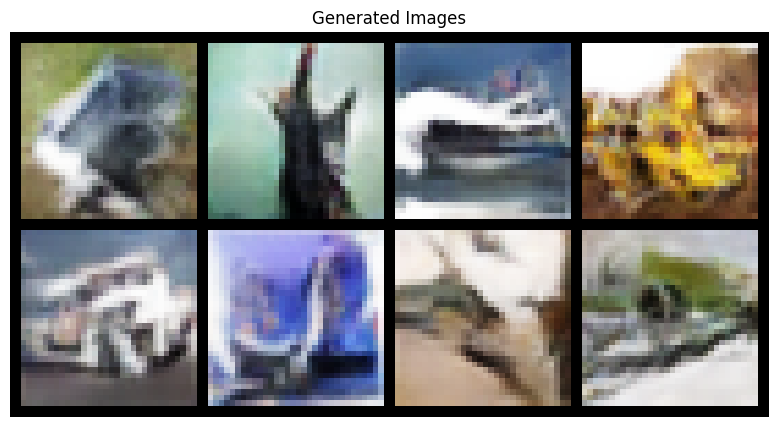

In [48]:
# Set the generator to evaluation mode and not to generate gradients anymore 
netG.eval()

noise = torch.randn(8, nz, 1, 1, device=device)

with torch.no_grad(): 
    fake_images = netG(noise).detach().cpu()

plt.figure(figsize=(10, 5))  
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(vutils.make_grid(fake_images, padding=2, normalize=True, nrow=4), (1, 2, 0)))
#plt.savefig("DCGAN Images.png", dpi = 300) 
plt.show()
        

### Latent Space Interpolation

In [379]:
z1 = torch.randn(1, nz, 1, 1, device=device)


In [388]:
z2 = torch.randn(1, nz, 1, 1, device=device)

In [389]:
z_interp = torch.zeros((7, nz, 1, 1))
z_interp[0, :] = z1 
z_interp[1, :] = z1*0.90 + z2*0.10
z_interp[2, :] = z1*0.75 + z2*0.25
z_interp[3, :] = z1*0.50 + z2*0.50
z_interp[4, :] = z1*0.25 + z2*0.75
z_interp[5, :] = z1*0.10 + z2*0.90
z_interp[6, :] = z2

z_interp= z_interp.to(device)

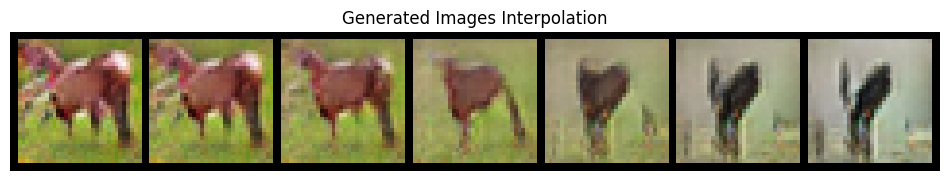

In [391]:
with torch.no_grad(): 
    fake_image_interp = netG(z_interp).detach().cpu()


plt.figure(figsize=(12, 7))  
plt.axis("off")
plt.title("Generated Images Interpolation")
plt.imshow(np.transpose(vutils.make_grid(fake_image_interp, padding=2, normalize=True, nrow = 7), (1, 2, 0)))
plt.savefig("DCGAN Image Interpolation.png", dpi = 300) 
plt.show()